/Users/nicholastorba/anaconda/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Optimization Finished!
Testing Accuracy: 0.333333


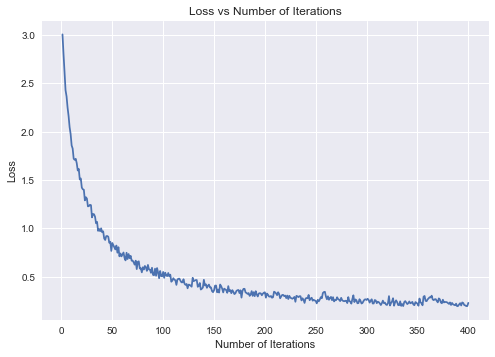

training steps: 400
learning rate: 0.002
number of hidden layers: 18
batch size: 199


In [1]:
import pretty_midi
import numpy as np
import itertools
import random
import glob
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib import rnn
import seaborn as sns
import matplotlib.pyplot as plt

#Checks current directory for the midi file extension and returns a list of all the midi files
def getMidi():
    return glob.glob("Midi_files/*.mid")

def getMidi2():
    return glob.glob("cl_mt_example_test/*.mid")

def chordTransform(chord): 
    #all possible triad chords
    triads = {
            'major' : [4, 3],
            'minor' : [3, 4],
            'dim' : [3, 3],
            'aug' : [4, 4]
        }
    
    #If not triad then returns a random note of the chord
    if len(chord) != 3:
        root_note = random.choice(chord)
        return root_note
    
    #Finds the corresponding notes and its root note
    root_chord = {}
    for note in chord:
        root_chord[note]= note%12
    
    # Get all possible permutations of these notes
    note_perms = list(itertools.permutations(list(root_chord.values())))

    # Test each permutation against the possible triad intervals and return the triad type if there's a match.
    for i in range(len(note_perms)-1):
        notes_intervals = []
        posRoot_note = 99
        root_note = 99

        # Loop through notes and create a list, length 2, of intervals to check against
        for j in range(len(chord)-1):
            
            #Stores the current and next note in the possible permutations
            note_A = note_perms[i][j]
            note_B = note_perms[i][j+1]
            
            #finds the interval
            interval = note_B - note_A
            
            #If the interval is negative then loops around just a different octave
            if interval < 0:
                interval = interval + 12
                
            #Store the interval
            notes_intervals.append(interval)
            
            #The lowest note is the possible root note so checks for that and stores it
            if note_A <= note_B:
                if note_A < posRoot_note:
                    posRoot_note = note_A
            if note_B <= note_A: 
                if note_B < posRoot_note:
                    posRoot_note = note_B
                    
        # Finally loop through the traids dict to see if we have a match for a triad
        for t in triads.keys():
            if triads[t] == notes_intervals:
                
                #If so the root note is the lowest note of the triad
                #This method finds a key given a value
                for real_root, pseudo_root in root_chord.items():
                    if pseudo_root == posRoot_note:
                        return real_root
            
    #If not then the root note is a random note from the collection of notes
    if root_note not in range(12):
        root_note = random.choice(list(root_chord.keys()))
        return root_note

#@inputs: note_array is a matrix that is 128xinstrument.get_piano_roll() long. The number of columns is dependent upon how
            # sample will be split by time

#@returns: a vector that contains the root note at each time sample
def instrument_to_vector(note_array):
    note_array_transpose = np.transpose(note_array)
    note_vector = np.empty(note_array.shape[1])
    note_vector.fill(-1)
    for i in range(note_array_transpose.shape[0]): #The i here will be the column number of the transpose, which is the note
                                                   #This loop should iterate through the number of columns in transpose
        note_list=[]
        for number in note_array_transpose[i]:
            if number!=-1:
                note_list.append(number) #add the number aka the note being played 
                                        # if there is no number there is no note played so that place is 0
            if len(note_list)!=1:
                note_vector[i]=-1
            else:
                note_vector[i]=note_list[0]
    return note_vector

def NoteMatrix(midi_data, samplesPerSec):
    #Defines how many samples per second
    fs = samplesPerSec

    #Returns the total amount of samples gotten
    y = np.arange(0, midi_data.get_end_time(), 1./fs).shape[0]

    #Our desired matrix has the amount of samples for every possible instrument
    noteMatrix = np.empty(shape=(128,y))
    noteMatrix.fill(-1)

    #Iterates through all the instruments of the midi song
    for instrument in midi_data.instruments:

        #Creates an array of all the notes the instrument can possibly play over a time sample and its velocity
        total_notes = np.asarray(instrument.get_piano_roll(fs=fs, times=np.arange(0, midi_data.get_end_time(), 1./fs)))
        total_notes[total_notes == 0] = -1
        
        #Holder for the final array that converts chords into notes making all instruments monophonic
        converted_notes = np.zeros(shape=total_notes.shape)

        #Goes through each time sample to see if notes repeat, if so find the root node of this chord
        i=0
        
        for column in total_notes.T:

            #Notes repeat in a time slice
            if count_nonNegOne(column) > 1:

                #create a list containing the notes played
                chord = np.where(column>=0)[0]
                
                if len(chord) > 0:
                    #finds the root note of the chord
                    root_note = chordTransform(chord)

                    #removes all other notes other than the root
                    for note in chord:
                        if note != root_note:
                            column[note] = -1

                    #Classify the time slice by the root note itself not velocity
                    column[root_note] = root_note

                #Store in the converted notes
            converted_notes[:, i] = column
            i += 1

        #As every time splice has only one note with the note defined, convert into vector
        instrument_vector = instrument_to_vector(converted_notes)

        #For that instrument store the vector of the notes played out of all
        noteMatrix[instrument.program] = instrument_vector
    return noteMatrix

#Testing purposes
def count_nonNegOne(array):
    count = 0
    for i in array:
        if i != -1:
            count += 1
    return count

#For the creation of the label array for the RNN
def get_label_vector(label):
    #Stores the correct label of the midi file by coverting the index value of at the corresponding genre to a 1
    #Is a vector for batch purposes
    label_array = np.zeros((7))
    label_dict = {'hh':0,
                 'cl':1,
                 'cn':2,
                 'ro':3,
                 'ed':4,
                 'pp':5,
                 'mt':6}
    label_array[label_dict[label]] = 1
    return label_array

def generateMidiData2(sampling):
    #number of samples per second
    fs = sampling

    #only gets the slice from 30 seconds to 90 seconds
    start = 30*fs
    end = 90*fs

    #Stores sequence length for tensorflow
    sequence_length = end-start

    #Makes an empty array of all the note matrices for all midis
    midi_note = np.zeros(shape=(len(getMidi2()),sequence_length,128))

    #Makes an empty of all the labels for each corresponding midi's note matrix
    midi_label = np.zeros(shape=(len(getMidi2()),7))

    #Stores the skipped indexs for the matrix and removes them after all conversions have been done
    bad_idx = []

    #Iterates through all midis
    for i in range(len(getMidi2())):
        #Gets specific midi path
        midi = getMidi2()[i]

        #Opens midi as a pretty midi file
        midi_data = pretty_midi.PrettyMIDI(midi)

        #creates the note matrix
        noteMatrix = NoteMatrix(midi_data, fs)

        #Stores the first minute
        noteMatrix = noteMatrix[:, start:end].T

        #If the currently made note matrix doesnt match required timesteps size, move to next index and store location
        if(noteMatrix.shape[0] != sequence_length):
            bad_idx.append(i)
            continue

        #convert index value of midi matrix with the current notematrix
        midi_note[i] = noteMatrix

        #stores the label of the midi file which is the first two letters of each midi after the path has been removed
        abbrev = midi.split("/")[1][:2]
        midi_label[i] = get_label_vector(abbrev)

    #Removes all the index values from the data that were skipped over    
    if(len(bad_idx) != 0):
        midi_note = np.delete(midi_note, bad_idx, axis=0)
        midi_label = np.delete(midi_label, bad_idx, axis=0)
    
    return midi_note, midi_label

def generateMidiData(sampling):
    #number of samples per second
    fs = sampling

    #only gets the slice from 30 seconds to 90 seconds
    start = 30*fs
    end = 90*fs

    #Stores sequence length for tensorflow
    sequence_length = end-start

    #Makes an empty array of all the note matrices for all midis
    midi_note = np.zeros(shape=(len(getMidi()),sequence_length,128))

    #Makes an empty of all the labels for each corresponding midi's note matrix
    midi_label = np.zeros(shape=(len(getMidi()),7))

    #Stores the skipped indexs for the matrix and removes them after all conversions have been done
    bad_idx = []

    #Iterates through all midis
    for i in range(len(getMidi())):
        #Gets specific midi path
        midi = getMidi()[i]

        #Opens midi as a pretty midi file
        midi_data = pretty_midi.PrettyMIDI(midi)

        #creates the note matrix
        noteMatrix = NoteMatrix(midi_data, fs)

        #Stores the first minute
        noteMatrix = noteMatrix[:, start:end].T

        #If the currently made note matrix doesnt match required timesteps size, move to next index and store location
        if(noteMatrix.shape[0] != sequence_length):
            bad_idx.append(i)
            continue

        #convert index value of midi matrix with the current notematrix
        midi_note[i] = noteMatrix

        #stores the label of the midi file which is the first two letters of each midi after the path has been removed
        abbrev = midi.split("/")[1][:2]
        midi_label[i] = get_label_vector(abbrev)

    #Removes all the index values from the data that were skipped over    
    if(len(bad_idx) != 0):
        midi_note = np.delete(midi_note, bad_idx, axis=0)
        midi_label = np.delete(midi_label, bad_idx, axis=0)
    
    return midi_note, midi_label


def train_test_split(raw_data_x, raw_data_y, decimal_split):
    #Creates a randoms set of numbers of the size data to randomize the raw data
    length = raw_data_x.shape[0]
    permutation = np.random.permutation(length)
    
    #Randomizes the data but makes sure that the x'values and the y'classifications stay correlated
    shuffled_raw_data_x = raw_data_x[permutation]
    shuffled_raw_data_y = raw_data_y[permutation]
    
    #Finds the length of the split
    idx = int(length * decimal_split)
    
    #Cuts the training, testing slices from the randomly shuffled sets
    train_x = shuffled_raw_data_x[:idx]
    test_x = shuffled_raw_data_x[idx:]
    train_y = shuffled_raw_data_y[:idx]
    test_y = shuffled_raw_data_y[idx:]
    return train_x, test_x, train_y, test_y

def RNN(x, weights, biases, timesteps, num_hidden):

    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.LSTMCell(num_hidden, forget_bias=1.0)

    #Dropout layer
    lstm_cell = rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.9)#0.9
    
    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

def main():
    
    #Splits the data randomly into testing and training
    fs = 20
    train_x, train_y = generateMidiData(fs)
    test_x, test_y = generateMidiData2(fs)
    #decimal_split = 0.85
    #train_x, test_x, train_y, test_y = train_test_split(midi_note, midi_label, decimal_split)
    
    # Training Parameters
    learning_rate = 0.002 #0.002
    training_steps = 400 #50
    batch_size = train_x.shape[0]
    display_step = 10

    # Network Parameters
    num_input = 128 #instruments
    timesteps = 60*fs # timesteps
    num_hidden = 18 #hidden layer num of features
    num_classes = 7 #Total amount of genres
    
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes])
    
    # Define weights and bias as normalized gaussian values to prevent issues from initializing as 0
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_classes]))
    }
    
    #Output of the RNN
    logits = RNN(X, weights, biases, timesteps, num_hidden)

    #Prediction made from the softmax output of the RNN
    prediction = tf.nn.softmax(logits)

    # Define loss and optimizer
    #Loss is the softman cross entropy as we are doing prediction and with logits as using outputs from RNN
    #Optimizer was ADAM as did best
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    #Gradient clipping
    #Deals with the exploding gradient problem
    gradients, variables = zip(*optimizer.compute_gradients(loss_op))

    #Clips it by the maximum L2 norm
    gradients, _ = tf.clip_by_global_norm(gradients, 1) #1.0

    #Apply the gradients to our optimizer
    train_op = optimizer.apply_gradients(zip(gradients, variables))

    # Evaluate model by taking the highest prediction and setting to 1
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
        
    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)
        loss_list = []
        #Runs for the defined epochs
        for step in range(1, training_steps+1):
            #Over all the data in the batch sizes
            for i in range(0, train_x.shape[0], batch_size):
                batch_x = train_x[i:i+batch_size]
                batch_y = train_y[i:i+batch_size]
                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
                #loss_for_list = sess.run([loss_op,accuracy])
                #loss_for_list.append(loss_list)
                
                #if step % 2 == 0:
                    # Calculate batch loss and accuracy
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                         Y: batch_y})
                loss_list.append(loss)
                   
                '''
                print("Step " + str(step) + ", Minibatch Loss= " + \
                          "{:.4f}".format(loss) + ", Training Accuracy= " + \
                          "{:.3f}".format(acc))
                '''
            
        print("Optimization Finished!")

        # Calculate accuracy for test over batch sizes also
        for i in range(0, test_x.shape[0], batch_size):
            testing_data = test_x[i:i+batch_size]
            testing_label = test_y[i:i+batch_size]
            print("Testing Accuracy:", \
                sess.run(accuracy, feed_dict={X: testing_data, Y: testing_label}))    
        
        
        sns.set_style("darkgrid")
        plt.plot(list(range(1,training_steps+1)), loss_list)
        plt.title("Loss vs Number of Iterations")
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt.show()
        
    sess.close()
    
    print('training steps: ' + str(training_steps))
    print('learning rate: '+ str(learning_rate))
    print('number of hidden layers: ' + str(num_hidden))
    print('batch size: '+str(batch_size))
        
if __name__== "__main__":
    main()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.plot(list(range(1,training_steps+1)), loss_list)
plt.title(loss)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

for i in range(0, train_x.shape[0], batch_size):
                batch_x = train_x[i:i+batch_size]
                batch_y = train_y[i:i+batch_size]
                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
                loss_for_list = sess.run([loss_op,accuracy])
                loss_for_list.append(loss_list)
                if step % display_step == 0 or step == 1:
                    # Calculate batch loss and accuracy
                    loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                         Y: batch_y})
                    loss_list.append(loss)
                    print("Step " + str(step) + ", Minibatch Loss= " + \
                          "{:.4f}".format(loss) + ", Training Accuracy= " + \
                          "{:.3f}".format(acc))